In [1]:
%matplotlib inline

import numpy as np
import collections
from collections import OrderedDict, Counter, defaultdict
import pandas as pd

import Bio
from Bio import SeqIO

import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show 
import matplotlib.patches as patches    
from matplotlib import colors


import glob

import subprocess
from subprocess import call

import re

import pickle

from Bio.SubsMat import MatrixInfo
import Bio.Data.CodonTable

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

/home/alla/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# gencode 25 metadata 
metadata_pc_g25 = pd.read_csv('tmp_res/metadata_pc_g25.txt', sep='\t')

# gencode 35 metadata 
metadata_pc_g35 = pd.read_csv('tmp_res/metadata_pc_g35.txt', sep='\t')

# open metadata with scores and metrics
meta = pd.read_csv('tmp_res/local_and_global_df_g25ovlp_g35ovlp_g38ovlp_refseqovlp_strand_FRAMES_PhyloCSF.txt', sep='\t')

In [3]:
PhyloSET = pd.read_csv('tmp_res/SET1.txt', sep='\t')

RiboSET = pd.read_csv('tmp_res/SET2.txt', sep='\t')

In [4]:
set(PhyloSET.gene.tolist()).intersection((RiboSET.gene.tolist()))

{'CCDC8', 'CYTH2', 'FXR2', 'H1FX', 'HNRNPA0', 'MARCKS', 'RPTOR', 'SFPQ'}

# Ribo-seq counts: unamb only 

In [5]:
# get total list of transcripts 

amb_path = 'data/counts_ext/download/N_term_amb/*'
unamb_path = 'data/counts_ext/download/N_term_unamb/*'

list_of_tr = list(set([tr_path.split('/')[-1].split('_counts')[0] for tr_path in glob.glob(unamb_path)+glob.glob(amb_path)]))

list_of_amb_tr = [tr_path.split('/')[-1].split('_counts')[0] for tr_path in glob.glob(amb_path)]

list_of_unamb_tr = [tr_path.split('/')[-1].split('_counts')[0] for tr_path in glob.glob(unamb_path)]

print (list_of_tr[0:3])

print (len(list_of_tr), len(list_of_amb_tr), len(list_of_unamb_tr))

['ENST00000506825', 'ENST00000274695', 'ENST00000562889']
76910 75232 75139


### combine amb and unamb reads

In [6]:
out_counts = {'amb':{}, 'unamb':{}, 'all':{}}

for i, tr_id in enumerate(list_of_tr):
    if tr_id in [x.split('.')[0] for x in PhyloSET.tr_id.tolist()]:
        
        # end of transcript = its length
        tr_length = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
        tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq
        gene = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
    
        
        if tr_id in list_of_amb_tr:
            tr_path_amb = 'data/counts_ext/download/N_term_amb/%s_counts.txt' % tr_id
            df_amb = pd.read_csv(tr_path_amb, sep='\t')
            d_amb = dict(zip(df_amb['pos'].tolist(), df_amb['Total'].tolist()))
            
            # add missing positions 
            for i in range(0, tr_length):
                if i not in d_amb:
                    d_amb[i] = 0
            
            
            out_counts['amb'][tr_id] = d_amb 
            
        else: # if tr_id is not in amb list
            print ('%s is not in amb list' % tr_id)
            
            
        if tr_id in list_of_unamb_tr:    
            
            tr_path_unamb = 'data/counts_ext/download/N_term_unamb/%s_counts.txt' % tr_id
            df_unamb = pd.read_csv(tr_path_unamb, sep='\t')
            d_unamb = dict(zip(df_unamb['pos'].tolist(), df_unamb['Total'].tolist()))
            
            for i in range(0, tr_length):
                if i not in d_unamb:
                    d_unamb[i] = 0
                
            out_counts['unamb'][tr_id] = d_unamb 
        
        else: # if tr_id is not in amb list
            print ('%s is not in unamb list' % tr_id)
            
            

ENST00000373521 is not in unamb list
ENST00000373519 is not in unamb list
ENST00000624244 is not in amb list


### frame counts for all reads (unamb+amb)

In [7]:
out_df_frames = {}

for tr_id in out_counts['all']:
    d = out_counts['all'][tr_id]
    # d = dict with positioons and counts 
    frames = {'Frame_1': {}, 'Frame_2': {}, 'Frame_3': {} }
    for pos, counts in d.items():
        if pos % 3 == 2:
            frames['Frame_1'][pos] = counts
        elif pos % 3 == 0:
            frames['Frame_2'][pos] = counts
        else:
            frames['Frame_3'][pos] = counts
    # make df 
    li1 = []
    li2 = []
    li3 = []
    
    # end of transcript = its length
    tr_length = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq
    gene = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
    
    for i in range(0, tr_length):
        if i in frames['Frame_1']:
            li1.append([i, int(frames['Frame_1'][i])])
        else:
            li1.append([i, int(0)])
    
    df1 = pd.DataFrame(li1, columns = ['Position', 'Frame 1']).sort_values(by='Position')
    
    for i in range(0, tr_length):
        if i in frames['Frame_2']:
            li2.append([i, int(frames['Frame_2'][i])])
        else:
            li2.append([i, int(0)])
    
    df2 = pd.DataFrame(li2, columns = ['Position', 'Frame 2']).sort_values(by='Position')
    
    for i in range(0, tr_length):
        if i in frames['Frame_3']:
            li3.append([i, int(frames['Frame_3'][i])])
        else:
            li3.append([i, int(0)])
    
    df3 = pd.DataFrame(li3, columns = ['Position', 'Frame 3']).sort_values(by='Position')
    
    df_f = df1.merge(df2, on='Position', how='inner').merge(df3, on='Position', how='inner')
    
    df_f['Sequence'] = list(tr_seq)
    
    df_f['Position'] = df_f['Position']-3
    
    df_f['rna_seq'] = None
    
    df_f[['Position', 'Sequence', 'Frame 1', 'Frame 2', 'Frame 3', 'rna_seq']].to_csv('data/TRIPSlike_plots_data_PhyloSET/%s_%s.csv' % (gene, tr_id), index=False)

            
    out_df_frames[tr_id] = df_f

### Frame counts only for unamb

In [8]:
out_df_frames_un = {}

for i, tr_id in enumerate(out_counts['unamb']):
    
    if i % 100 == 0:
        print (i)
        
    d = out_counts['unamb'][tr_id]
    # d = dict with positioons and counts 
    frames = {'Frame_1': {}, 'Frame_2': {}, 'Frame_3': {} }
    for pos, counts in d.items():
        if pos % 3 == 2:
            frames['Frame_1'][pos] = counts
        elif pos % 3 == 0:
            frames['Frame_2'][pos] = counts
        else:
            frames['Frame_3'][pos] = counts
    # make df 
    li1 = []
    li2 = []
    li3 = []
    
    # end of transcript = its length
    tr_length = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    tr_seq = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq
    gene = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene
    
    for i in range(1, tr_length+1):
        if i in frames['Frame_1']:
            li1.append([i, int(frames['Frame_1'][i])])
        else:
            li1.append([i, int(0)])
    
    df1 = pd.DataFrame(li1, columns = ['Position', 'Frame 1']).sort_values(by='Position')
    
    for i in range(1, tr_length+1):
        if i in frames['Frame_2']:
            li2.append([i, int(frames['Frame_2'][i])])
        else:
            li2.append([i, int(0)])
    
    df2 = pd.DataFrame(li2, columns = ['Position', 'Frame 2']).sort_values(by='Position')
    
    for i in range(1, tr_length+1):
        if i in frames['Frame_3']:
            li3.append([i, int(frames['Frame_3'][i])])
        else:
            li3.append([i, int(0)])
    
    df3 = pd.DataFrame(li3, columns = ['Position', 'Frame 3']).sort_values(by='Position')
    
    df_f = df1.merge(df2, on='Position', how='inner').merge(df3, on='Position', how='inner')
    
    df_f['Sequence'] = list(tr_seq)
    
    df_f['Position'] = df_f['Position'] -1 #-3
    
    df_f['rna_seq'] = None
    
    df_f[['Position', 'Sequence', 'Frame 1', 'Frame 2', 'Frame 3', 'rna_seq']].to_csv('data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), index=False)

            
    out_df_frames_un[tr_id] = df_f

0


In [9]:
# save it out_df_frames_un 

with open('data/out_df_frames_un_dict_phyloset.pickle', 'wb') as handle:
    pickle.dump(out_df_frames_un, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot examples 

In [98]:
len(list(out_counts['unamb'].keys()))

83

In [99]:
print ('tr_id w/o unamb reads:', set([x.split('.')[0] for x in PhyloSET.tr_id.tolist()]) - set(list(out_counts['unamb'].keys())))

print ('PABPC1L2A', 'PABPC1L2B')

tr_id w/o unamb reads: {'ENST00000373519', 'ENST00000373521'}
PABPC1L2A PABPC1L2B


In [100]:
print ('tr_id w/o amb reads:', set([x.split('.')[0] for x in PhyloSET.tr_id.tolist()]) - set(list(out_counts['amb'].keys())))

tr_id w/o amb reads: {'ENST00000624244'}


In [35]:
def prepare_data_for_trips2(meta, file_counts, metadata_pc_g25, 
                           tr_id, gene, l, p, fraq, cds, 
                           predicted_ext_start=False, figsize=(20, 10),
                           xlims='full', zeros=True, name='test.png', linew=9):
    
    f = pd.read_csv(file_counts)
    f.columns = ['Position', 'Sequence', 'Frame1', 'Frame2', 'Frame3', 'RNASeq']
    
    atgs_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}
    stop_pos = {'frame_0':[], 'frame_1':[], 'frame_2':[]}

    for pos in f.Position.tolist():
        codon = ''.join(f.Sequence.tolist()[(pos-1):(pos-1+3)])
        if codon == 'ATG':
            if pos % 3 == 0:
                atgs_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                atgs_pos['frame_1'].append(pos)
            else:
                atgs_pos['frame_2'].append(pos)
            
        elif (codon == 'TGA') | (codon == 'TAA') | (codon == 'TAG'):
            if pos % 3 == 0:
                stop_pos['frame_0'].append(pos)
            elif pos % 3 == 1:
                stop_pos['frame_1'].append(pos)
            else:
                stop_pos['frame_2'].append(pos)
        else:
            continue     
            
    # add CDS borders
    cds_stop_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos
    cds_start_pos = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos + 1
    cds_start_codon = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_codon
    
    if xlims == 'ext':
        xlim1 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1
        xlim2 = meta[meta['tr_id'].str.contains(tr_id)].iloc[0].N_term_end1 + 50*3
    elif len(xlims) == 2:
        xlim1 = xlims[0]
        xlim2 = xlims[1]
    else: # full transcript
        xlim1 = 0
        xlim2 = len(metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].transcript_seq)
    
    d = {}
    
    d['cds_stop_pos'] = cds_stop_pos
    d['cds_start_pos'] = cds_start_pos
    d['cds_start_codon'] = cds_start_codon
    d['f'] = f
    d['stop_pos'] = stop_pos
    d['atgs_pos'] = atgs_pos
    d['xlims'] = (xlim1, xlim2)
    d['predicted_ext_start'] = predicted_ext_start
    d['l'] = l
    d['p'] = p
    d['figsize'] = figsize
    d['fraq'] = fraq
    d['cds'] = cds
    d['name'] = tr_id+'_'+gene
    d['zeros'] = zeros
    d['linew'] = linew
    
    return d


def trips_full2(d, name='test', font1=38, font2=45):
    
    l = d['l']
    p = d['p']
    f = d['f'] # dict with frames 
    atgs_pos = d['atgs_pos']
    stop_pos = d['stop_pos']
    cds_start_pos = d['cds_start_pos']
    cds_stop_pos = d['cds_stop_pos']
    figsize = d['figsize']
    xlims = d['xlims']
    fraq = d['fraq']
    cds = d['cds']
    name = d['name']
    zeros = d['zeros']
    linewidth = d['linew'] 
    
    fig, axes = plt.subplots(4, 1, figsize = figsize, 
                             gridspec_kw={'height_ratios':[10,1.5,1,1]}, sharex=True, sharey=False)

    main_plot = axes[0]
    #cds = axes[1]
    #orfs = axes[1]
    red = axes[1]
    green = axes[2]
    blue = axes[3]

    # x 
    main_plot.set_xlim(f.Position.min(), f.Position.max()+1)

    # y
    
    if xlims is not False:
        f1 = f[xlims[0]:xlims[1]]
        max_height = np.max([np.max(f1.Frame1.tolist()), np.max(f1.Frame2.tolist()), np.max(f1.Frame3.tolist())])
        print (max_height)
    else:
        max_height = np.max([np.max(f.Frame1.tolist()), np.max(f.Frame2.tolist()), np.max(f.Frame3.tolist())])
        print (max_height)
        
    #### ????? why they dissappear????? ######    
    main_plot.set_ylim(0, max_height+max_height/l)
    main_plot.set_yticks(np.arange(0, max_height+max_height/l, p))
    main_plot.set_yticklabels(np.arange(0, max_height+max_height/l, p, dtype=np.int64), fontsize=font1)
    
    # print (f[125:150])

    # #frame 1 = red, frame2 = green, frame3 = blue
    if zeros == True:
        main_plot.plot(f.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(f.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
    else:
        # delete zeros 
        t = f[['Position', 'Frame1']]
        fr1 = t[t['Frame1'] != 0]
        
        t = f[['Position', 'Frame2']]
        fr2 = t[t['Frame2'] != 0]
        
        t = f[['Position', 'Frame3']]
        fr3 = t[t['Frame3'] != 0]
        
        main_plot.plot(fr1.Position.tolist(), fr1.Frame1.tolist(), color = 'coral', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr2.Position.tolist(), fr2.Frame2.tolist(), color = 'mediumseagreen', linewidth=linewidth, linestyle='-')
        main_plot.plot(fr3.Position.tolist(), fr3.Frame3.tolist(), color = 'cornflowerblue', linewidth=linewidth, linestyle='-')
    
        
        
        
    red.set_facecolor('coral')
    green.set_facecolor('mediumseagreen')
    blue.set_facecolor('cornflowerblue')
    #cds.set_facecolor('lightgrey')

    #blue.set_xticks(np.arange(0, f.Position.max(), 50))
    #blue.set_xticklabels(np.arange(0, f.Position.max(), 50), fontsize=45)

    red.set_yticklabels(())
    green.set_yticklabels(())
    blue.set_yticklabels(())
    #cds.set_yticklabels(())
    #orfs.set_yticklabels(())
    
    

    blue.set_ylabel('f2', fontsize=font1)#, rotation = 0)
    red.set_ylabel('f0', fontsize=font1)#, rotation = 0)
    green.set_ylabel('f1', fontsize=font1)#, rotation = 0)
    #cds.set_ylabel('cds', fontsize=35)#, rotation = 0)
    #orfs.set_ylabel('orf', fontsize=font1)#, rotation = 0)

    for frame, pos_li in atgs_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='white', linewidth=linewidth-1)
            
    for frame, pos_li in stop_pos.items():
        if frame == 'frame_0':
            for pos in pos_li:
                blue.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        elif frame == 'frame_1':
            for pos in pos_li:
                red.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
        else:
            for pos in pos_li:
                green.vlines(pos, ymin = 0, ymax = 1, colors='black', linewidth=linewidth-1)
            
                    
    # add start of annotated CDS
    main_plot.vlines(cds_stop_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    main_plot.vlines(cds_start_pos, ymin=0, ymax=max_height+max_height/l, colors='black', linewidth=linewidth-2)
    #main_plot.text(x = cds_stop_pos-100, y = max_height+max_height/10, s = 'cds stop', fontsize=39)
    #main_plot.text(x = cds_start_pos-10, y = max_height+0.1, s = 'cds start', fontsize=39)


    # add rectangle = CDS
    #if cds is True:
        #rect = patches.Rectangle((cds_start_pos, 0),cds_stop_pos-cds_start_pos,
                         #1,linewidth=1,edgecolor='r',facecolor='lightgrey')
        #cds.add_patch(rect)

        # add non-AUG - cds_start_pos
        #cds.text(x = cds_start_pos, y = 0.3, s = 'AUG', fontsize=38)

    
    # add rectangle = extended CDS
    xlims = d['xlims']
    predicted_ext_start = d['predicted_ext_start']
    if xlims is not False:
        if predicted_ext_start is not False:
            Nst = int(predicted_ext_start.split('_')[0])
            codon_name = predicted_ext_start.split('_')[1]
            N2 = cds_stop_pos
            rect = patches.Rectangle((Nst, 0), N2-Nst,1,linewidth=1,edgecolor='r',facecolor='silver')
            #orfs.add_patch(rect)
        
            #orfs.text(x = Nst, y = 0.3, s = codon_name, fontsize=font1)

    
    blue.set_xticks(range(f.Position.min(), f.Position.max()+1, fraq))       
    blue.set_xticklabels(range(f.Position.min(), f.Position.max()+1, fraq), fontsize=font1)
    
    print (f.Position.min())
    
    
    if xlims is not False:    
        plt.xlim(xlims[0], xlims[1])

        
        
    main_plot.set_title(name, fontsize=font2)
    plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)
    
    #plt.savefig('plots/'+name+'.png', dpi = 300, bbox_inches = 'tight')
    

146
0


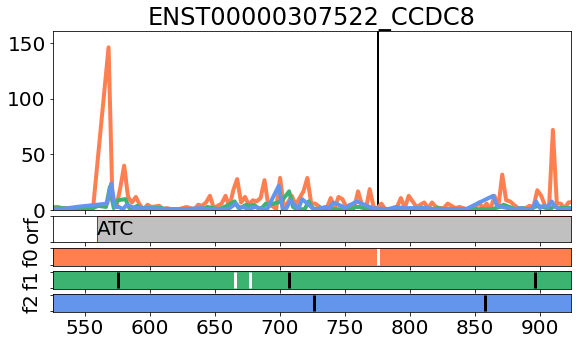

In [11]:
gene = 'CCDC8'

tr_id = 'ENST00000307522'


pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = pos_pred_start + '_' + pred_start

xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = 'CCDC8_phyloset.png', font1=20, font2=24)

99
0


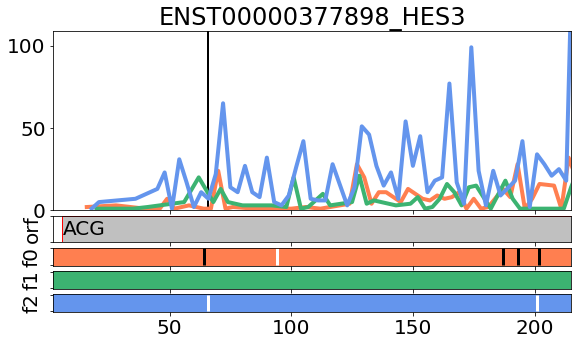

In [12]:
gene = 'HES3'

tr_id = 'ENST00000377898'


pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = pos_pred_start + '_' + pred_start

xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = 'HES3_phyloset.png', font1=20, font2=24)

In [13]:
PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary

'ACG; 6-66; Rank: 1907; cov: 40.0'

1925
0


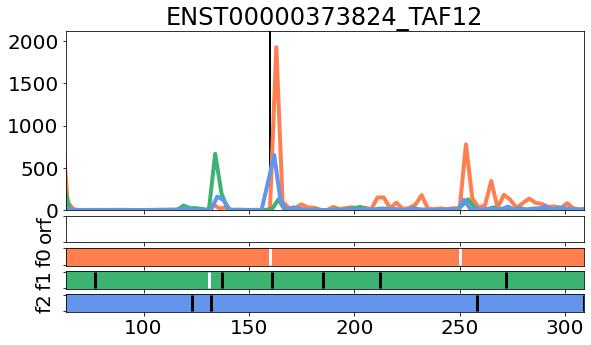

In [14]:
gene = 'TAF12'

tr_id = 'ENST00000373824'

try:
    pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
    pos_pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
    pre_st = pos_pred_start + '_' + pred_start
except:
    pred_start = None
    pos_pred_start = None
    pre_st = False



xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = 'TAF12_phyloset.png', font1=20, font2=24)

4912
0


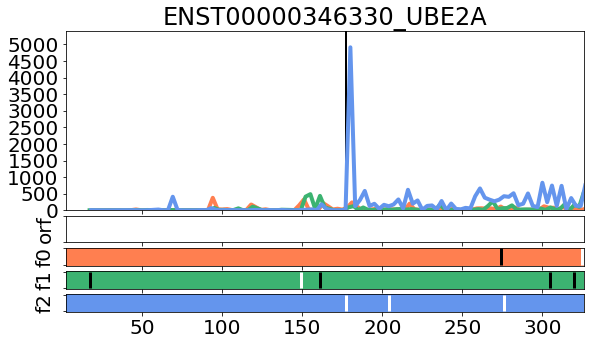

In [15]:
gene = 'UBE2A'

tr_id = 'ENST00000346330'

try:
    pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
    pos_pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
    pre_st = pos_pred_start + '_' + pred_start
except:
    pred_start = None
    pos_pred_start = None
    pre_st = False



xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = 'UBE2A_phyloset.png', font1=20, font2=24)

# PhyloCSF: get CDS counts and get all Ribo-seq pred ranks 

146
0


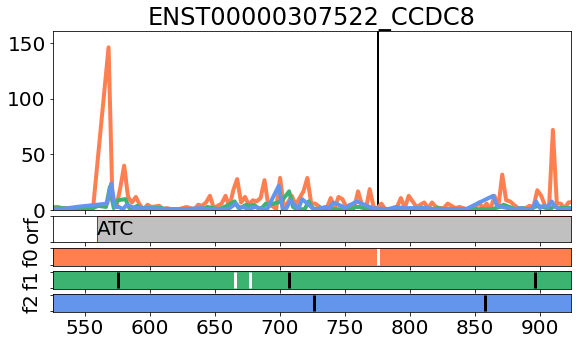

In [64]:
gene = 'CCDC8'

tr_id = 'ENST00000307522'


pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
pos_pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 


pre_st = pos_pred_start + '_' + pred_start

xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*3]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50, 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = 'CCDC8_phyloset.png', font1=20, font2=24)

In [16]:
out_df_li = []

for tr_id, df_count in out_df_frames_un.items():
    cds_start = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos 
    cds_stop = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos 
    cds_length = cds_stop - cds_start
    gene = metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].gene 
    Riboseq_Summary = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary
    Coverage_value_ext = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Coverage_value_ext
        
    if cds_start % 3 == 0:
        #print ('remainder: ', cds_start % 3, 'frame1')
        read_counts = df_count[cds_start-1:cds_stop]['Frame 1'].sum()
    elif cds_start % 3 == 1:
        read_counts = df_count[cds_start-1:cds_stop]['Frame 2'].sum()
        #print ('remainder: ', cds_start % 3, 'frame2')
    else:
        read_counts = df_count[cds_start-1:cds_stop]['Frame 3'].sum()
        #print ('remainder: ', cds_start % 3, 'frame3')
        
        #print ('counts in 1', df_count[cds_start-1:cds_stop]['Frame 1'].sum())
        #print ('counts in  2', df_count[cds_start-1:cds_stop]['Frame 2'].sum())
        #print ('counts in  3', df_count[cds_start-1:cds_stop]['Frame 3'].sum())
        
    # slice df and get counts in the correct frame
    out_df_li.append([tr_id, gene, cds_length, read_counts, np.round(read_counts/cds_length, 2), Riboseq_Summary, Coverage_value_ext])
   


out_df = pd.DataFrame(out_df_li, columns = ['tr_id', 'gene', 'cds_length', 
                                            'read_counts', 'normalised_read_counts', 'Riboseq_Summary', 'Coverage_value_ext'])

In [87]:
list_with_no_reads = ['PABPC1L2A', 'PABPC1L2B']
list_with_CDS_reads_only = []

In [17]:
out_df[out_df['normalised_read_counts'] >= 2].gene.nunique()

27

In [18]:
out_df[out_df['normalised_read_counts'] < 2].gene.nunique()

31

# Plot Ribo-seq profiles of all genes

In [151]:
tmp2 = out_df[out_df['normalised_read_counts'] >= 1.5].sort_values(by='normalised_read_counts', ascending=False)

tmp = out_df[out_df['normalised_read_counts'] >= 2].sort_values(by='normalised_read_counts', ascending=False)

print (tmp.gene.nunique(), tmp2.gene.nunique())

print (set(tmp2.gene.tolist()) - set(tmp.gene.tolist()))

27 32
{'MAP3K5', 'SULT1A1', 'CCDC8', 'TRPC1', 'HELZ2'}


In [148]:
out_df[out_df['gene'] == 'CCDC8']

,tr_id,gene,cds_length,read_counts,normalised_read_counts,Riboseq_Summary,Coverage_value_ext
36,ENST00000307522,CCDC8,1617,2759,1.71,ATC; 559-775; Rank: 400; cov: 79.1,79.104478


ENST00000314940 HNRNPA0 ATA; 248-311; Rank: 6; cov: 93.75
9412
0


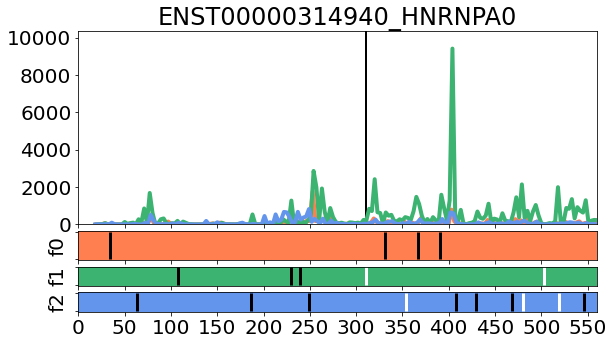

In [170]:
tr_id = tmp.iloc[0].tr_id
gene = tmp.iloc[0].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000333762 H1FX CTG; 223-376; Rank: 58; cov: 80.43
3350
0


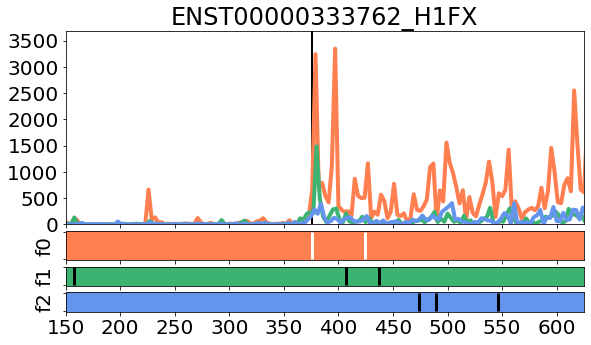

In [53]:
tr_id = tmp.iloc[1].tr_id
gene = tmp.iloc[1].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [150,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000357214 SFPQ GTG; 37-100; Rank: 9; cov: 81.25
12339
0


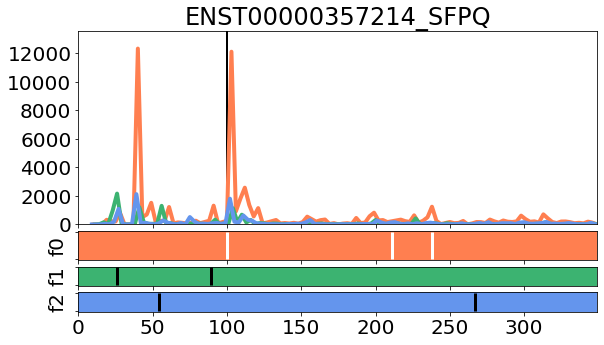

In [56]:
tr_id = tmp.iloc[2].tr_id
gene = tmp.iloc[2].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000521688 ENY2 nan
7539
0


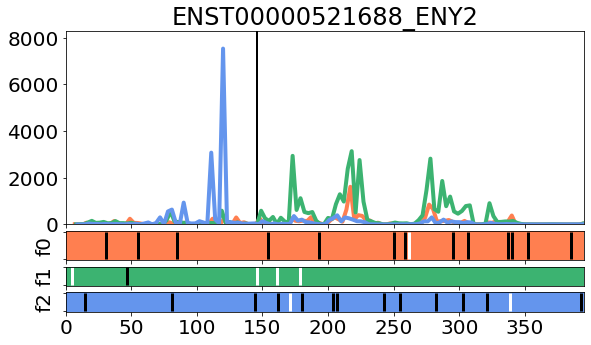

In [57]:
tr_id = tmp.iloc[3].tr_id
gene = tmp.iloc[3].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2000,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000371558 UBE2A nan
4912
0


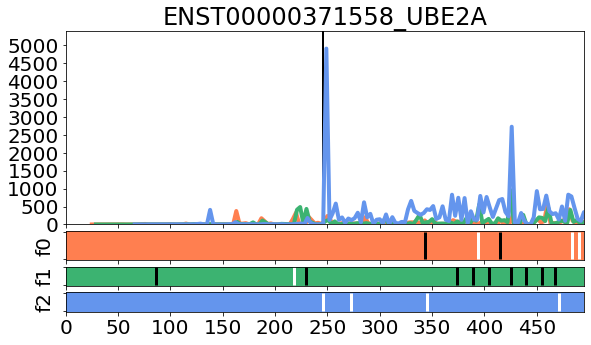

In [59]:
tr_id = tmp.iloc[4].tr_id
gene = tmp.iloc[4].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000612661 MARCKS TTG; 349-385; Rank: 151; cov: 57.14
5218
0


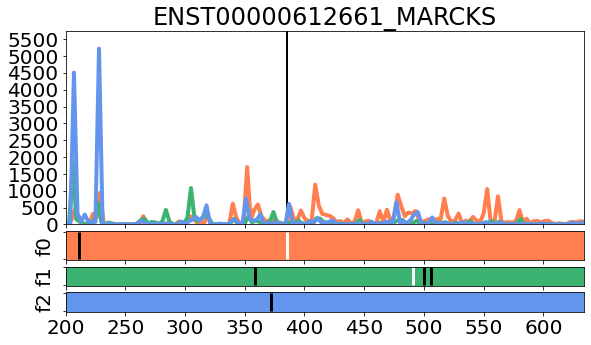

In [64]:
tr_id = tmp.iloc[8].tr_id
gene = tmp.iloc[8].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [200,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =500,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000373824 TAF12 nan
6000
0


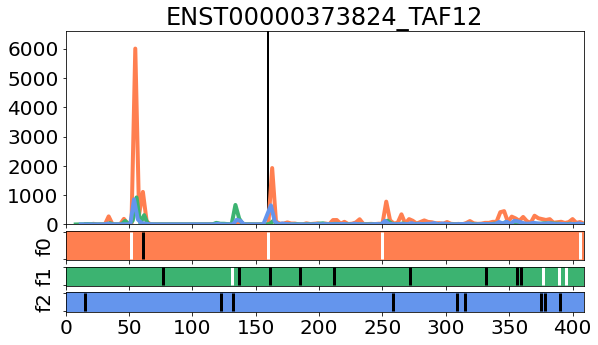

In [66]:
tr_id = tmp.iloc[9].tr_id
gene = tmp.iloc[9].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000536578 GLOD4 nan
3
0


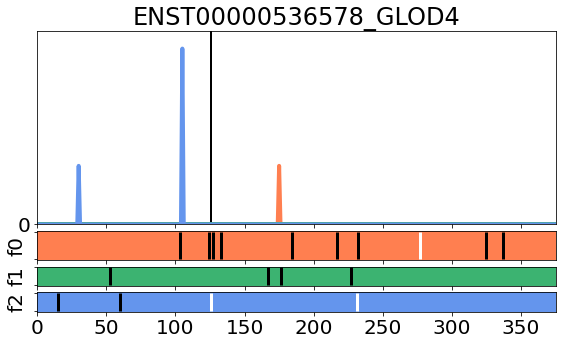

In [69]:
tr_id = tmp.iloc[10].tr_id
gene = tmp.iloc[10].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =1000,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000226225 TNFAIP1 ACG; 211-268; Rank: 776; cov: 57.14
1285
0


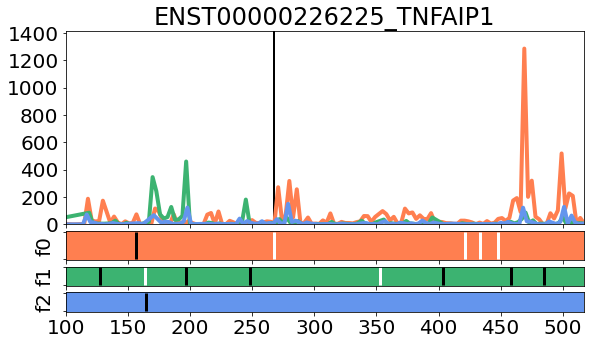

In [73]:
tr_id = tmp.iloc[11].tr_id
gene = tmp.iloc[11].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [100,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000336156 KIAA0930 nan
491
0


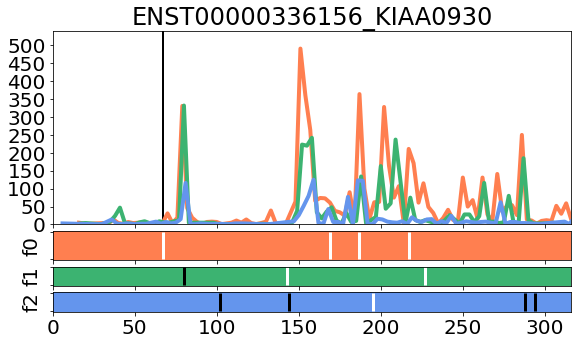

In [76]:
tr_id = tmp.iloc[12].tr_id
gene = tmp.iloc[12].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000250113 FXR2 GTG; 117-336; Rank: 110; cov: 70.59
713
0


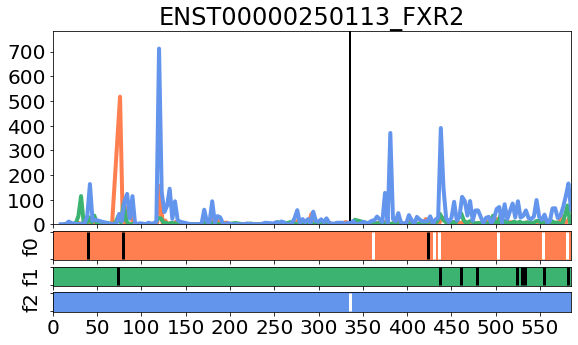

In [78]:
tr_id = tmp.iloc[13].tr_id
gene = tmp.iloc[13].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000306917 FEM1B GTG; 580-616; Rank: 1394; cov: 28.57
672
0


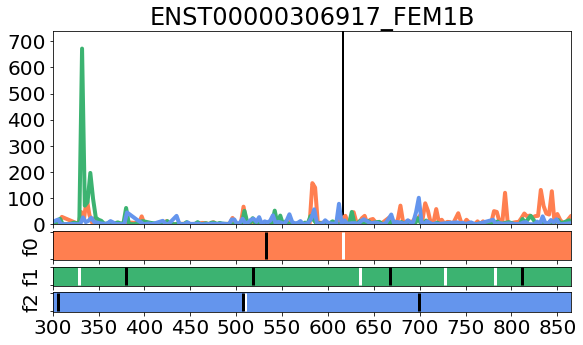

In [81]:
tr_id = tmp.iloc[14].tr_id
gene = tmp.iloc[14].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [300,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000452733 CYTH2 GTG; 369-477; Rank: 255; cov: 74.19
811
0


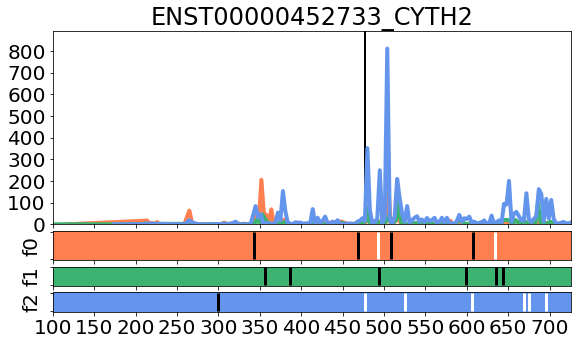

In [85]:
tr_id = tmp.iloc[16].tr_id
gene = tmp.iloc[16].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [100,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000430524 RANBP1 nan
49
0


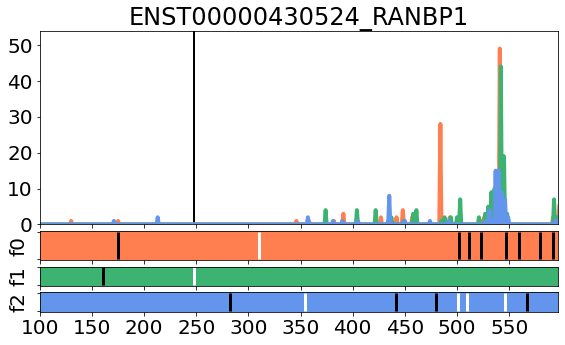

In [89]:
tr_id = tmp.iloc[17].tr_id
gene = tmp.iloc[17].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [100,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000306801 RPTOR AGG; 306-363; Rank: 333; cov: 85.71
194
0


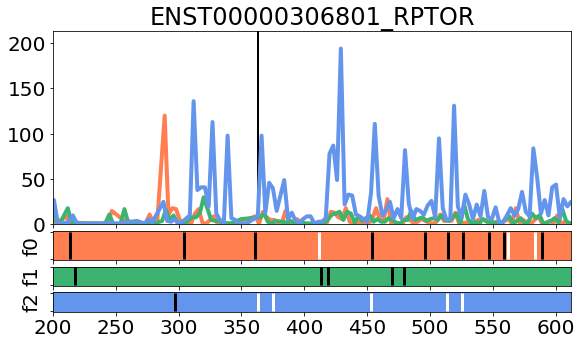

In [95]:
tr_id = tmp.iloc[20].tr_id
gene = tmp.iloc[20].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [200,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000261537 MIB1 GTG; 121-265; Rank: 1004; cov: 60.47
168
0


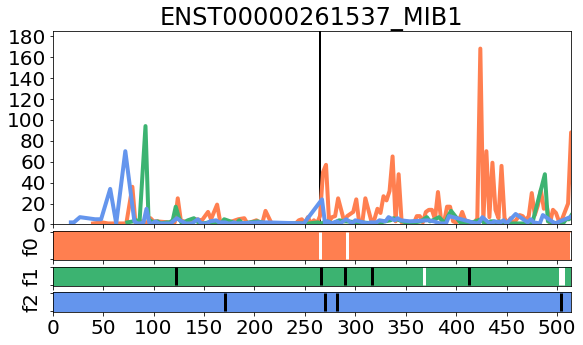

In [97]:
tr_id = tmp.iloc[21].tr_id
gene = tmp.iloc[21].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000267460 PELI2 ACG; 116-287; Rank: 640; cov: 51.92
1137
0


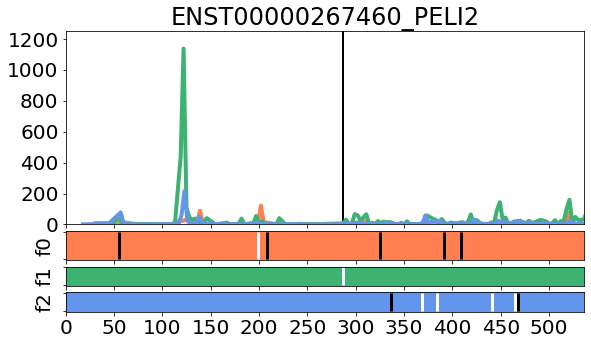

In [100]:
tr_id = tmp.iloc[22].tr_id
gene = tmp.iloc[22].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =200,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000318348 GLTP nan
590
0


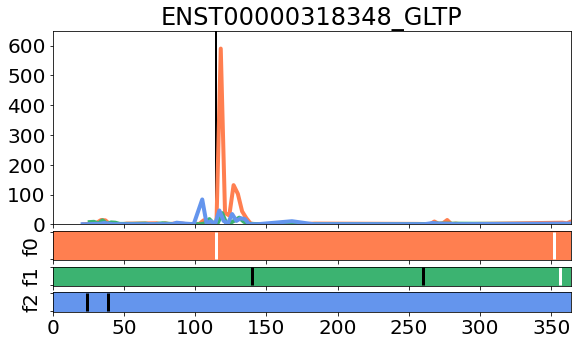

In [102]:
tr_id = tmp.iloc[23].tr_id
gene = tmp.iloc[23].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =100,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000377898 HES3 ACG; 6-66; Rank: 1907; cov: 40.0
188
0


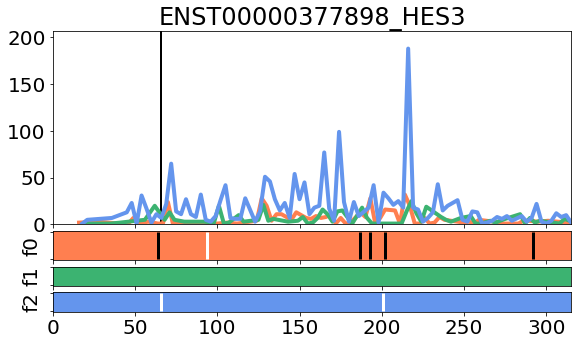

In [104]:
tr_id = tmp.iloc[24].tr_id
gene = tmp.iloc[24].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000455833 IFFO2 CTG; 301-355; Rank: 924; cov: 61.54
171
0


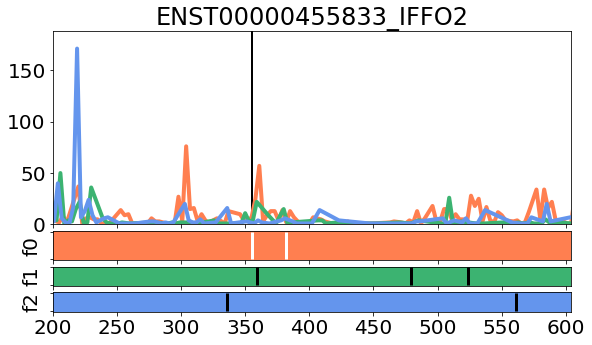

In [111]:
tr_id = tmp.iloc[25].tr_id
gene = tmp.iloc[25].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [200,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000368061 VANGL2 ATA; 331-475; Rank: 787; cov: 58.14
128
0


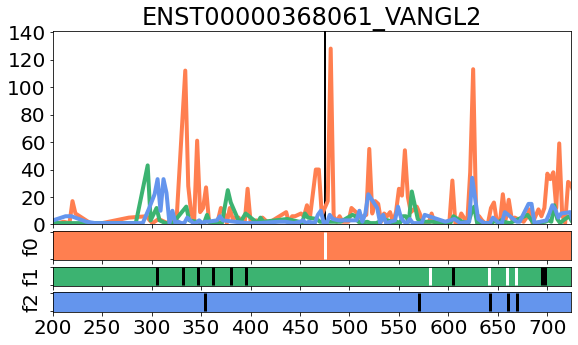

In [116]:
tr_id = tmp.iloc[26].tr_id
gene = tmp.iloc[26].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [200,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000400907 RERE nan
233
0


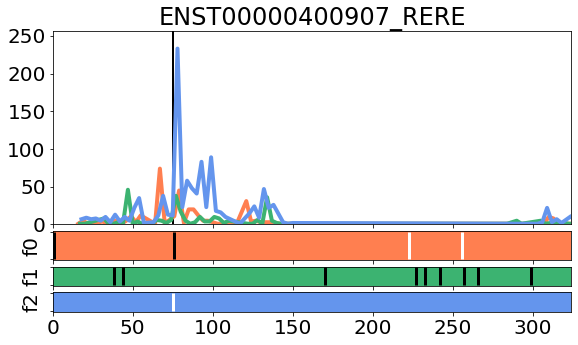

In [120]:
tr_id = tmp.iloc[27].tr_id
gene = tmp.iloc[27].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000374360 DLG3 GTG; 99-234; Rank: 4589; cov: 5.0
4
0


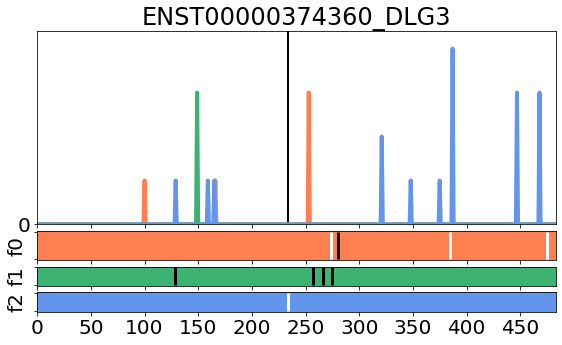

In [122]:
tr_id = tmp.iloc[28].tr_id
gene = tmp.iloc[28].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =50,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000349880 NAV2 CTG; 250-331; Rank: 1626; cov: 50.0
61
0


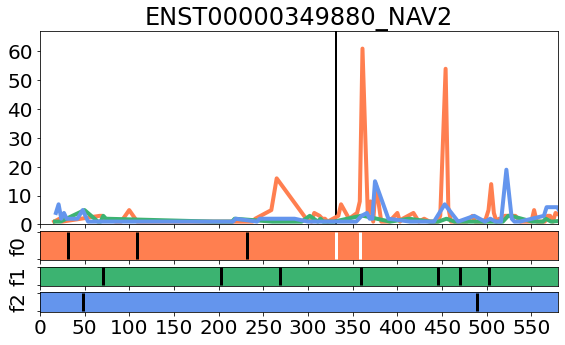

In [125]:
tr_id = tmp.iloc[30].tr_id
gene = tmp.iloc[30].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000471182 PLEKHG3 nan
60
0


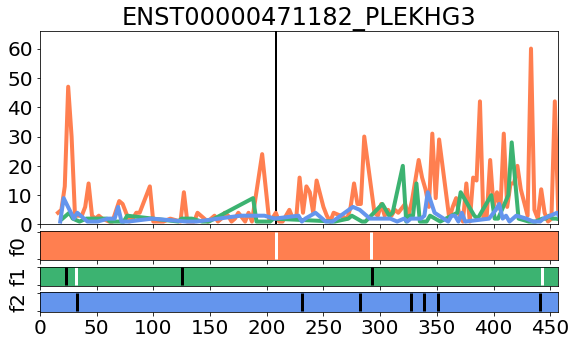

In [128]:
tr_id = tmp.iloc[31].tr_id
gene = tmp.iloc[31].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

In [171]:
out_df[out_df['gene'] == 'PLEKHG3']

,tr_id,gene,cds_length,read_counts,normalised_read_counts,Riboseq_Summary,Coverage_value_ext
59,ENST00000471182,PLEKHG3,2259,6545,2.9,NaN,NaN


ENST00000372851 RIMS4 AAG; 11-68; Rank: 2538; cov: 28.57
86
0


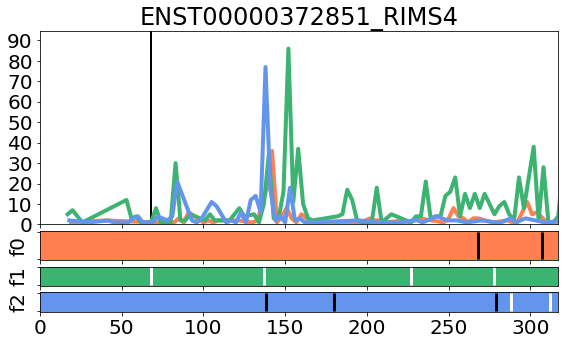

In [133]:
tr_id = tmp.iloc[36].tr_id
gene = tmp.iloc[36].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000393350 MAF nan
46
0


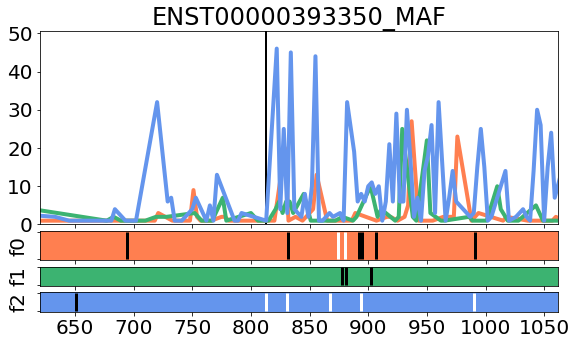

In [143]:
tr_id = tmp.iloc[37].tr_id
gene = tmp.iloc[37].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [620,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000326043 MAF AAG; 714-813; Rank: 1683; cov: 42.86
46
0


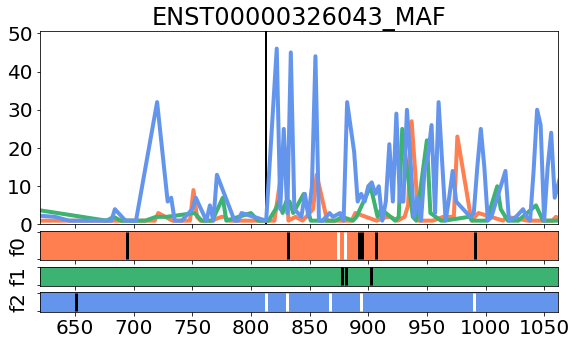

In [144]:
tr_id = tmp.iloc[38].tr_id
gene = tmp.iloc[38].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [620,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

MAP3K5', 'SULT1A1', 'CCDC8', 'TRPC1', 'HELZ2'

ENST00000273482 TRPC1 ACG; 59-392; Rank: 2177; cov: 33.96
56
0


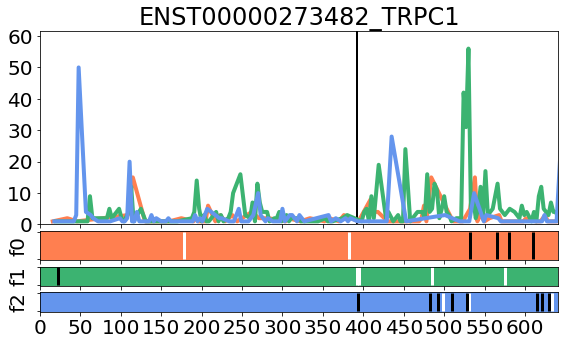

In [155]:
tmp3 = tmp2[tmp2['gene'].isin(['MAP3K5', 'SULT1A1', 'CCDC8', 'TRPC1', 'HELZ2'])]

tr_id = tmp3.iloc[0].tr_id
gene = tmp3.iloc[0].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000467148 HELZ2 GTG; 5-71; Rank: 1824; cov: 47.06
49
0


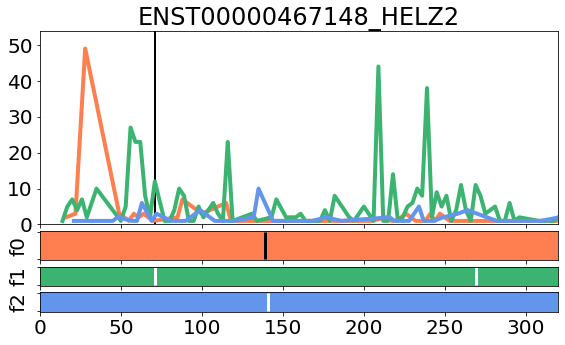

In [156]:
tr_id = tmp3.iloc[1].tr_id
gene = tmp3.iloc[1].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000476941 TRPC1 nan
56
0


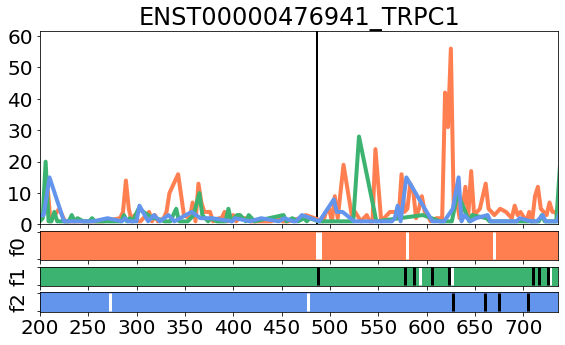

In [158]:
tr_id = tmp3.iloc[2].tr_id
gene = tmp3.iloc[2].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [200,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000359015 MAP3K5 CTG; 125-362; Rank: 1113; cov: 51.35
107
0


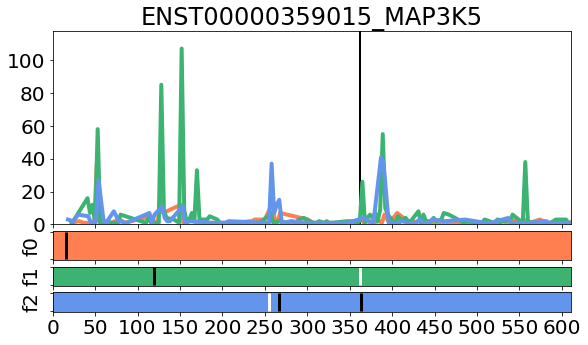

In [160]:
tr_id = tmp3.iloc[3].tr_id
gene = tmp3.iloc[3].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000307522 CCDC8 ATC; 559-775; Rank: 400; cov: 79.1
146
0


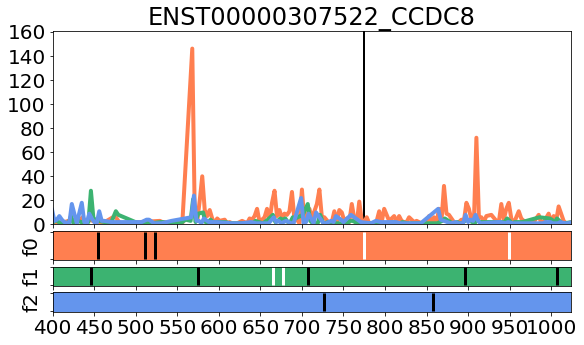

In [165]:
tr_id = tmp3.iloc[4].tr_id
gene = tmp3.iloc[4].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [400,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000350842 SULT1A1 nan
176
0


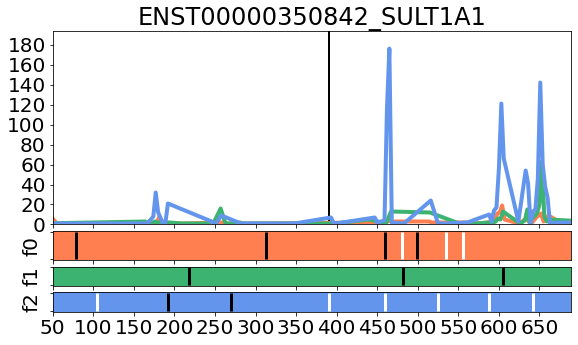

In [168]:
tr_id = tmp3.iloc[5].tr_id
gene = tmp3.iloc[5].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [50,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*6]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

# Remaining genes (CDS_cov < 1.5)

In [177]:
tmp = out_df[out_df['normalised_read_counts'] <= 1.5].sort_values(by='normalised_read_counts', ascending=False)

ENST00000380861 WWC3 CTG; 200-392; Rank: 766; cov: 66.1
59
0


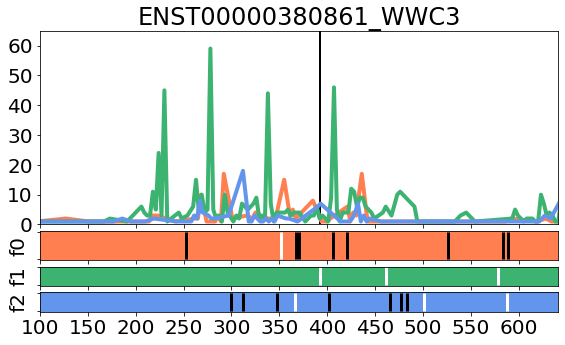

In [179]:
tr_id = tmp.iloc[0].tr_id
gene = tmp.iloc[0].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [100,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000621775 USP27X CTG; 52-361; Rank: 722; cov: 70.41
110
0


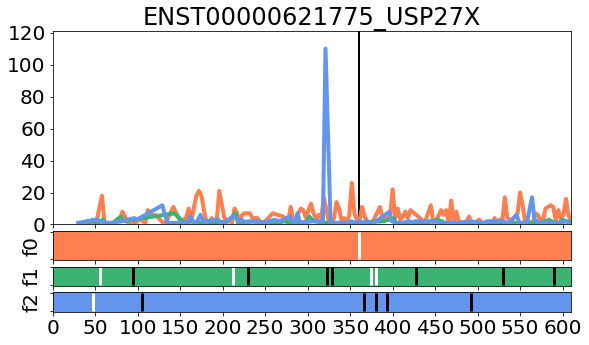

In [181]:
tr_id = tmp.iloc[1].tr_id
gene = tmp.iloc[1].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =20,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000603841 FBXW7 nan
29
0


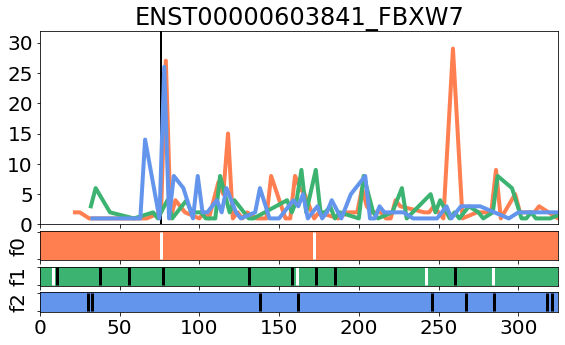

In [183]:
tr_id = tmp.iloc[2].tr_id
gene = tmp.iloc[2].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000262158 SMAD7 GTG; 33-288; Rank: 2852; cov: 23.75
72
0


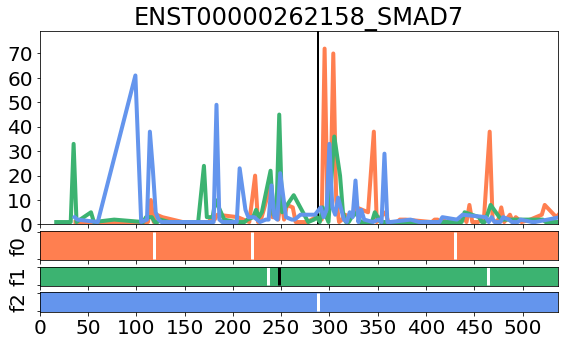

In [186]:
tr_id = tmp.iloc[3].tr_id
gene = tmp.iloc[3].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000232974 ZBTB47 AAG; 213-282; Rank: 2657; cov: 27.78
71
0


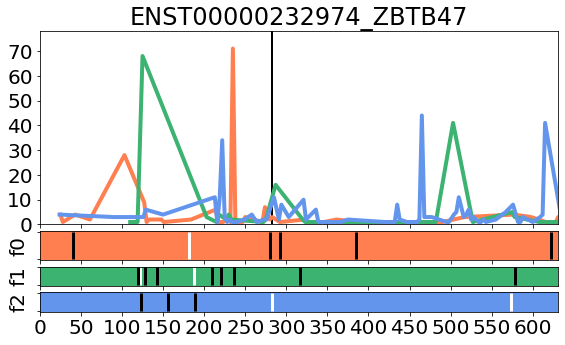

In [188]:
tr_id = tmp.iloc[4].tr_id
gene = tmp.iloc[4].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50, 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000351898 SLC4A4 nan
40
0


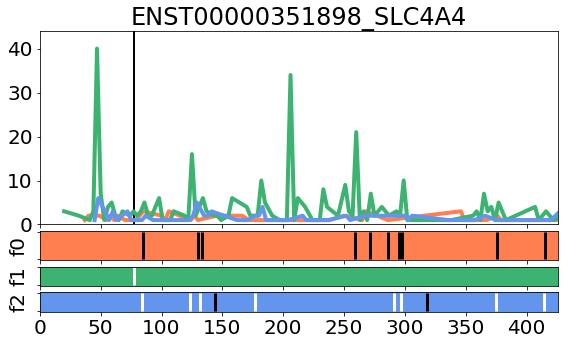

In [189]:
tr_id = tmp.iloc[5].tr_id
gene = tmp.iloc[5].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000379919 MAB21L1 TTG; 991-1072; Rank: 1950; cov: 40.91
14
0


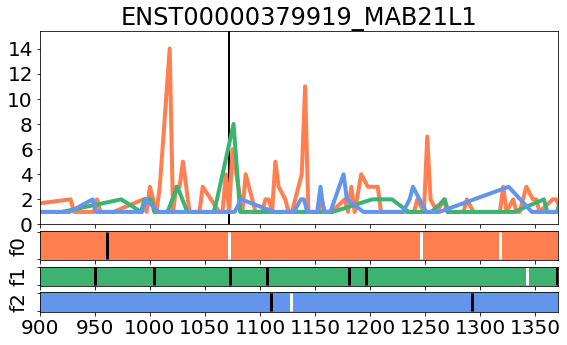

In [198]:
tr_id = tmp.iloc[7].tr_id
gene = tmp.iloc[7].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [900,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*6]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2,  #y axis tick 
                             fraq = 50,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000636345 NRXN1 nan
74
0


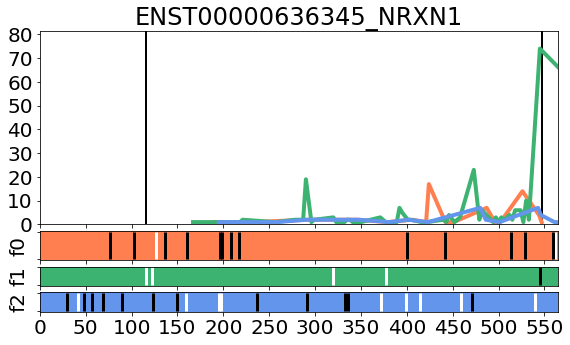

In [202]:
tr_id = tmp.iloc[8].tr_id
gene = tmp.iloc[8].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000330271 ACTL10 GTG; 536-1001; Rank: 1732; cov: 31.33
52
0


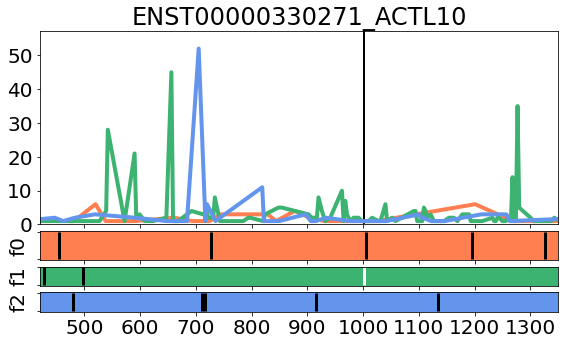

In [209]:
tr_id = tmp.iloc[9].tr_id
gene = tmp.iloc[9].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [420,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000270458 CACNG8 GTG; 20-104; Rank: 4636; cov: 4.35
32
0


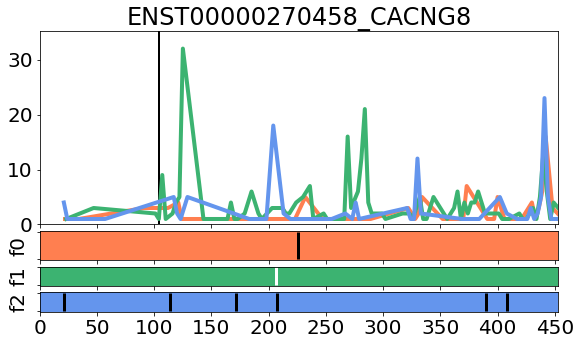

In [211]:
tr_id = tmp.iloc[10].tr_id
gene = tmp.iloc[10].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*7]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =10,  #y axis tick 
                             fraq = 50,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000396884 SOX10 ACG; 146-284; Rank: 3286; cov: 17.07
14
0


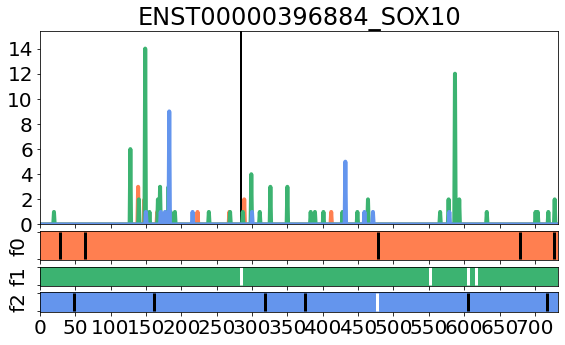

In [216]:
tr_id = tmp.iloc[11].tr_id
gene = tmp.iloc[11].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2,  #y axis tick 
                             fraq = 50,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=True)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000635322 OAZ3 nan
15
0


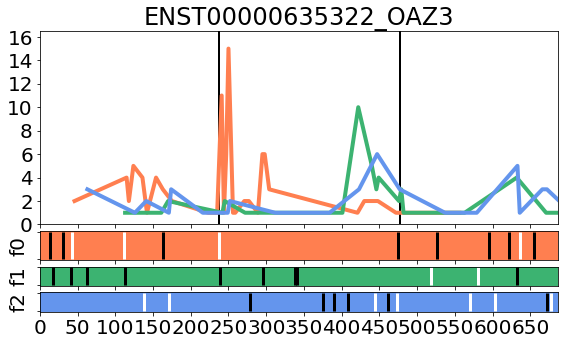

In [218]:
tr_id = tmp.iloc[13].tr_id
gene = tmp.iloc[13].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =2,  #y axis tick 
                             fraq = 50,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000317605 MAB21L2 TTG; 1052-1109; Rank: 4331; cov: 7.14
32
0


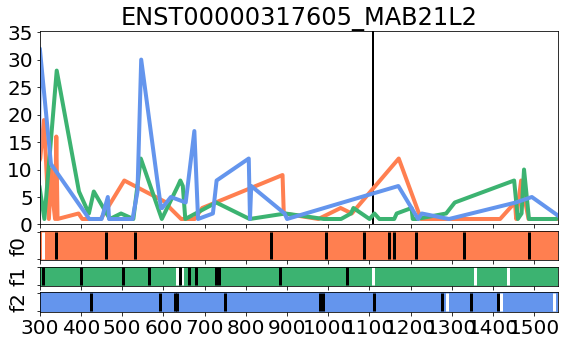

In [221]:
tr_id = tmp.iloc[14].tr_id
gene = tmp.iloc[14].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [300,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000239151 HOXB5 ATC; 211-280; Rank: 3536; cov: 16.67
7
0


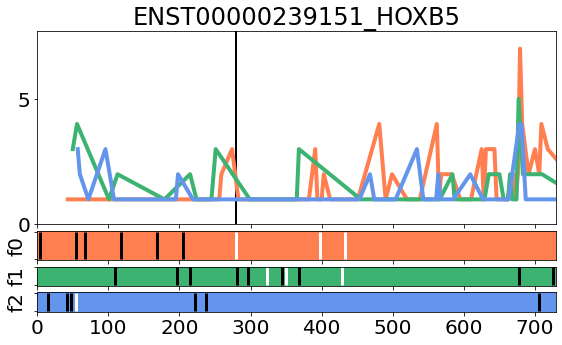

In [222]:
tr_id = tmp.iloc[15].tr_id
gene = tmp.iloc[15].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000619991 C1QL3 nan
13
0


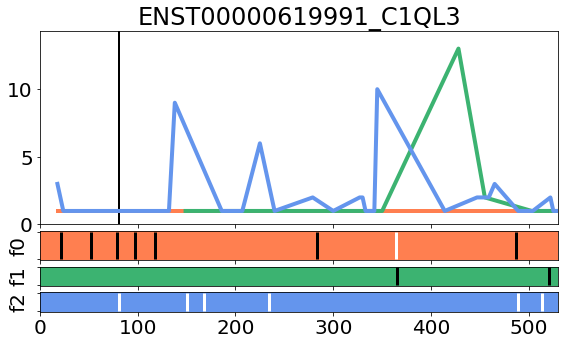

In [223]:
tr_id = tmp.iloc[16].tr_id
gene = tmp.iloc[16].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000402859 LRP5L nan
16
0


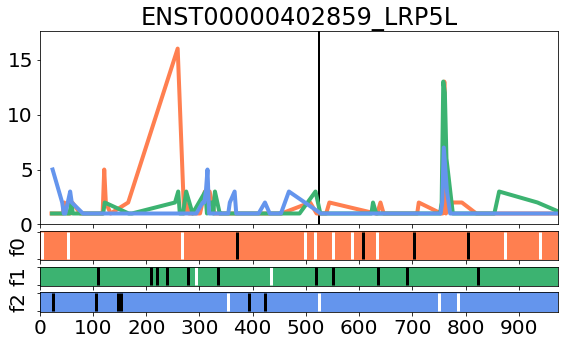

In [227]:
tr_id = tmp.iloc[21].tr_id
gene = tmp.iloc[21].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000462833 ADCY5 CTG; 1130-1214; Rank: 5631; cov: 0.0
6
0


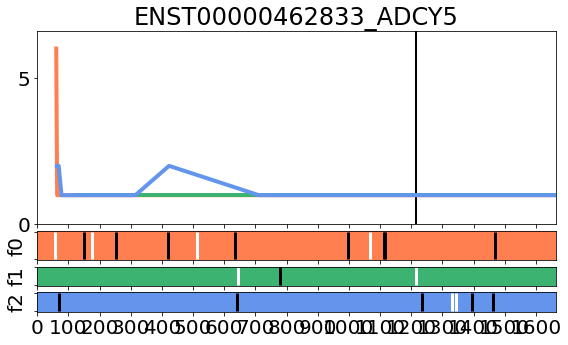

In [230]:
tr_id = tmp.iloc[24].tr_id
gene = tmp.iloc[24].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000272520 C1QL2 GTG; 549-621; Rank: 4509; cov: 5.26
5
0


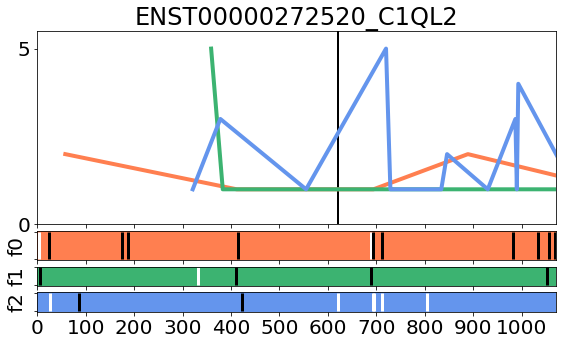

In [231]:
tr_id = tmp.iloc[25].tr_id
gene = tmp.iloc[25].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000310842 POMZP3 AAG; 656-686; Rank: 2117; cov: 40.0
2
0


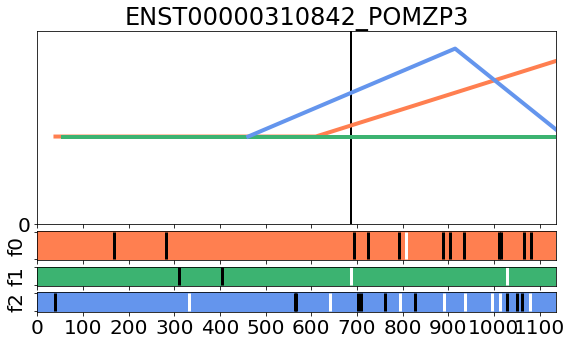

In [232]:
tr_id = tmp.iloc[26].tr_id
gene = tmp.iloc[26].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000530069 ALDH3B2 nan
6
0


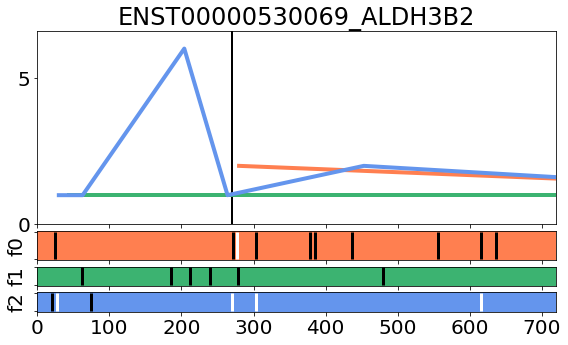

In [233]:
tr_id = tmp.iloc[27].tr_id
gene = tmp.iloc[27].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000579181 TBC1D29 nan
1
0


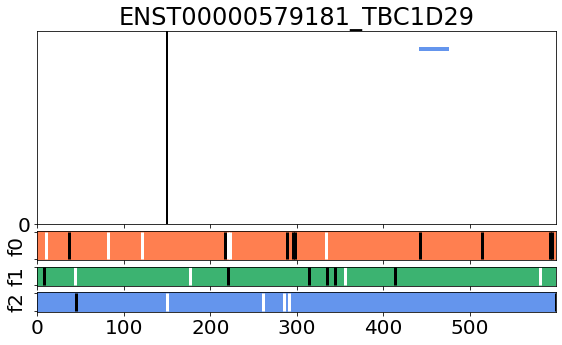

In [236]:
tr_id = tmp.iloc[30].tr_id
gene = tmp.iloc[30].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000382435 SLC35G5 AGG; 178-220; Rank: 5004; cov: 0.0
2
0


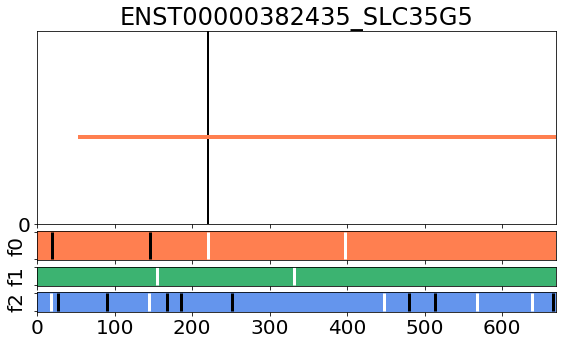

In [237]:
tr_id = tmp.iloc[31].tr_id
gene = tmp.iloc[31].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000287766 SLC6A1 ATC; 377-422; Rank: 4084; cov: 10.0
1
0


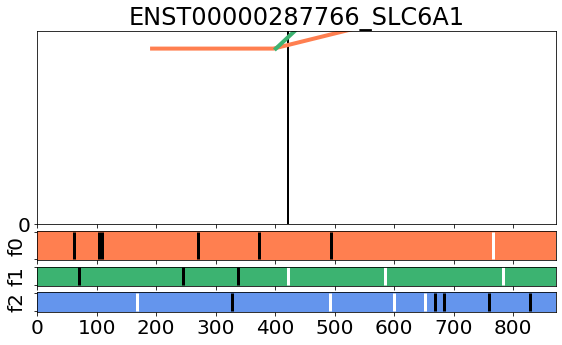

In [238]:
tr_id = tmp.iloc[32].tr_id
gene = tmp.iloc[32].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000374375 GDF5OS AGG; 377-443; Rank: 5739; cov: 0.0
10
0


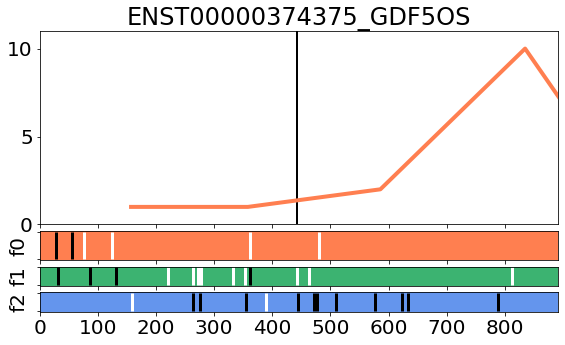

In [239]:
tr_id = tmp.iloc[33].tr_id
gene = tmp.iloc[33].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000624244 AC007906.1 ATT; 73-124; Rank: 5040; cov: 0.0
1
0


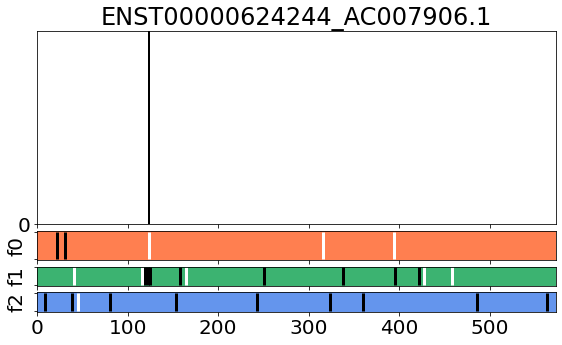

In [240]:
tr_id = tmp.iloc[34].tr_id
gene = tmp.iloc[34].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000580161 TBC1D29 nan
5
0


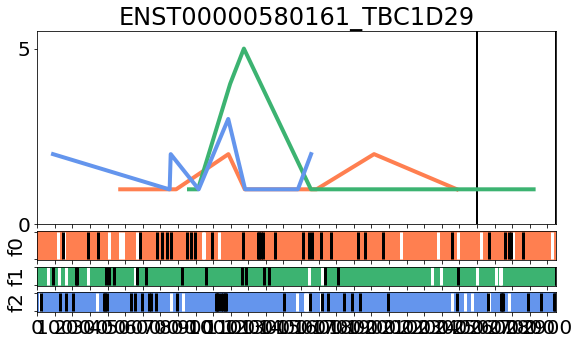

In [241]:
tr_id = tmp.iloc[35].tr_id
gene = tmp.iloc[35].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

ENST00000392915 MAP3K19 ATA; 646-685; Rank: 5323; cov: 0.0
0
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


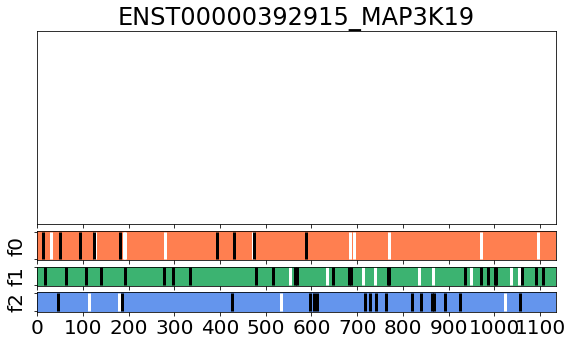

In [242]:
tr_id = tmp.iloc[36].tr_id
gene = tmp.iloc[36].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

In [244]:
tr_id = tmp.iloc[38].tr_id
gene = tmp.iloc[38].gene

print (tr_id, gene, PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary)
#xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
#         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*5]

xlims = [0,
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_start_pos+50*9]

d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 100,
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

IndexError: single positional indexer is out-of-bounds

In [246]:
6+22+24+8

60

# Rank > 500 and <= 1000

In [187]:
PhyloSET_tmp = PhyloSET[PhyloSET['Riboseq_Summary'].notna()]
PhyloSET_tmp['rank'] = [int(x.split('; ')[2].split(': ')[1]) if x != None else None for x in PhyloSET_tmp['Riboseq_Summary'].tolist()]

PhyloSET_tmp[(PhyloSET_tmp['rank'] <= 1000) & (PhyloSET_tmp['rank'] > 500)].gene.nunique()

/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


6

In [188]:
list(PhyloSET_tmp[(PhyloSET_tmp['rank'] <= 1000) & (PhyloSET_tmp['rank'] > 500)].gene.unique())

['IFFO2', 'VANGL2', 'PELI2', 'TNFAIP1', 'WWC3', 'USP27X']

# UpsetR 

* 8/60 = ribo-seq+phyloset (rank <=500)
* 6/60 = phyloset with rank > 500 and <= 1000

* (27-)/60 = rank > 1000 or no rank, CDS is translated
* Y/60 = no translation data shown for CDS 

In [205]:
remaining_genes = list(set(PhyloSET['gene'].tolist()) - set(['IFFO2', 'VANGL2', 'PELI2', 'TNFAIP1', 'WWC3', 'USP27X']+['CCDC8', 'CYTH2', 'FXR2', 'H1FX', 'HNRNPA0', 'MARCKS', 'RPTOR', 'SFPQ']))

print (len(remaining_genes))

46


In [206]:
no_rank_or_greater_1000_CDS_transl = out_df[(out_df['normalised_read_counts'] >= 0.5) & (out_df['gene'].isin(remaining_genes))].gene.unique()

print (len(no_rank_or_greater_1000_CDS_transl))

26


In [208]:
remaining_genes2 = list(set(remaining_genes) - set(no_rank_or_greater_1000_CDS_transl))

print (len(remaining_genes2), 60-6-8-26)

20 20


OAZ3 ENST00000635322
15
0
OAZ3 ENST00000627780
15
0
OAZ3 ENST00000321531
15
0
C1QL2 ENST00000272520
23
0
MAP3K19 ENST00000392915
1
0
SLC6A1 ENST00000287766
3
0
ADCY5 ENST00000462833
27
0
MAB21L2 ENST00000317605
23
0
POMZP3 ENST00000275569
2
0
POMZP3 ENST00000310842
8
0
SLC35G5 ENST00000382435
0
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


C1QL3 ENST00000298943
18
0
C1QL3 ENST00000619991
18
0
ALDH3B2 ENST00000530069
6
0
ALDH3B2 ENST00000349015
6
0
AC007906.1 ENST00000624244
1
0
TBC1D29 ENST00000580161
1
0
TBC1D29 ENST00000584297
0
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.


TBC1D29 ENST00000579181
1
0
HOXB5 ENST00000239151
10
0
CACNG8 ENST00000270458


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


32
0
ACTL10 ENST00000330271
59
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


GDF5OS ENST00000374375
10
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


LRP5L ENST00000610821


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


32
0
LRP5L ENST00000402859
32
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


LRP5L ENST00000444995
32
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


LRP5L ENST00000402785
32
0


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


SOX10 ENST00000396884
29


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0
SOX10 ENST00000360880
29


/home/alla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0
PABPC1L2B ENST00000373521


FileNotFoundError: [Errno 2] No such file or directory: 'data/TRIPSlike_plots_data_PhyloSET/PABPC1L2B_ENST00000373521_unamb.csv'

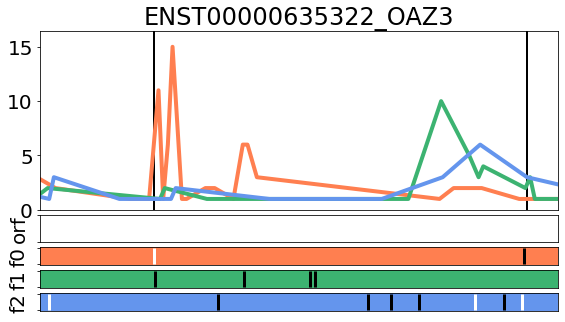

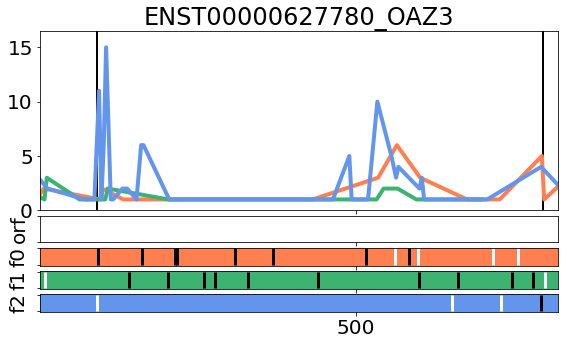

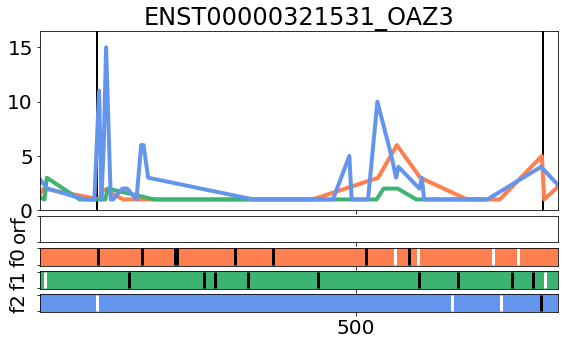

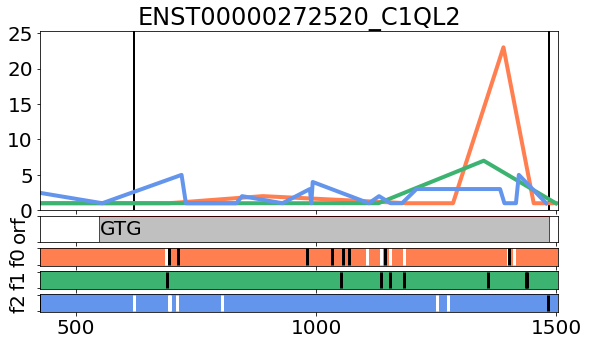

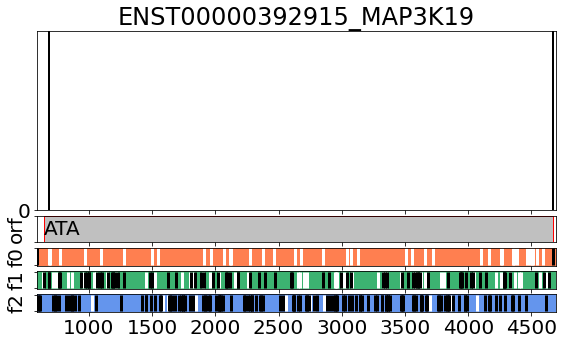

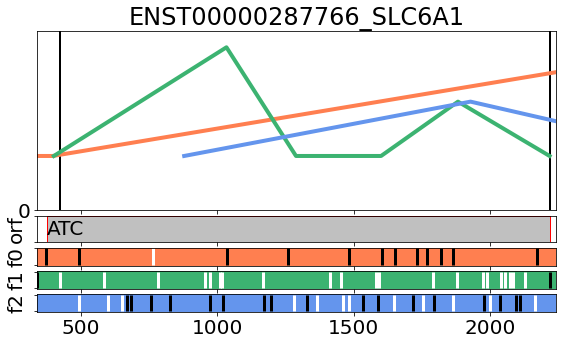

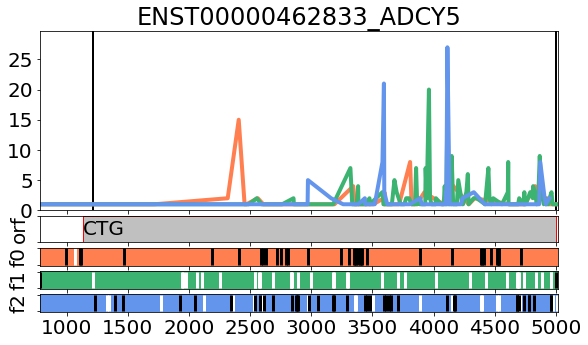

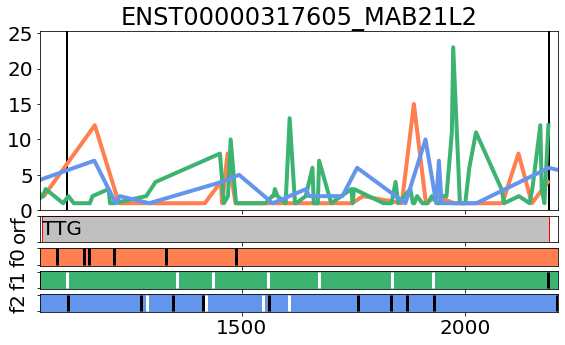

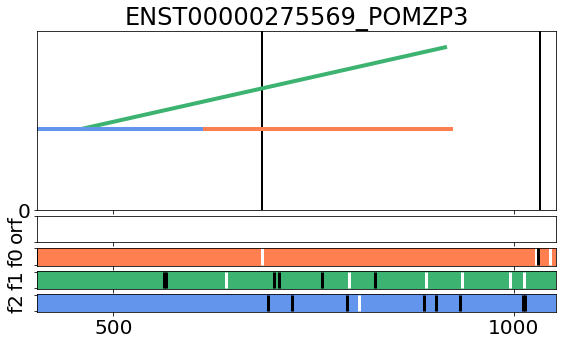

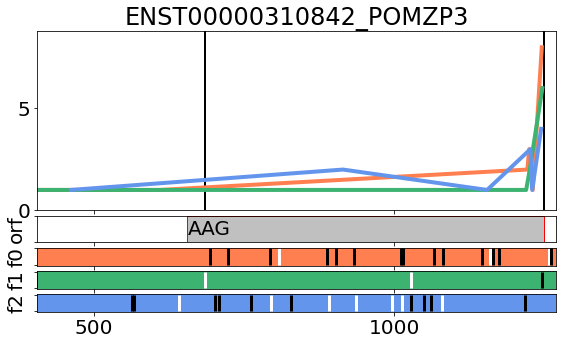

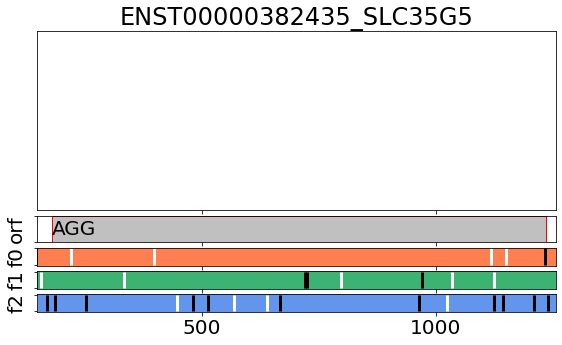

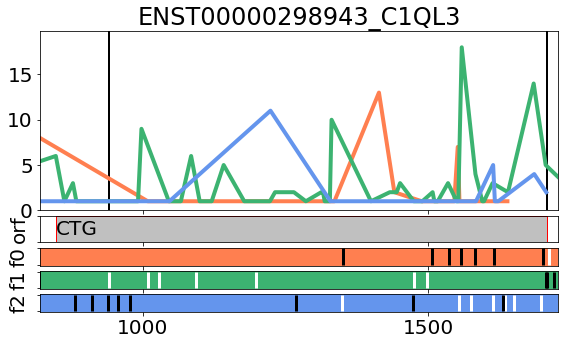

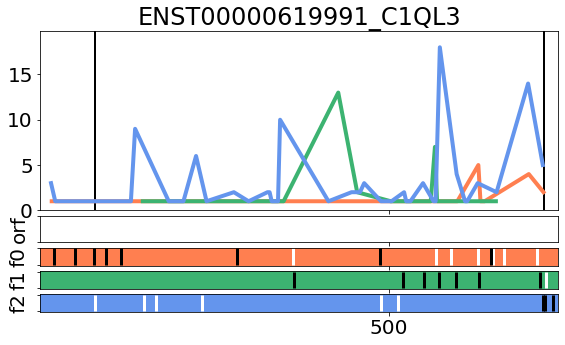

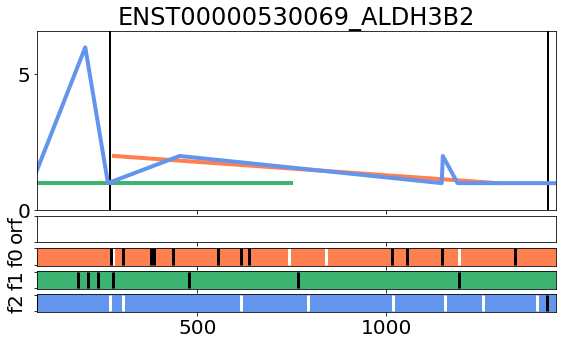

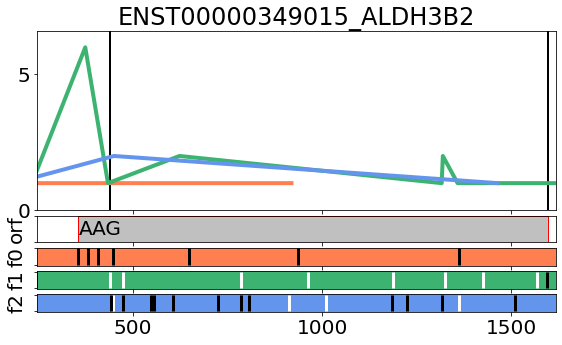

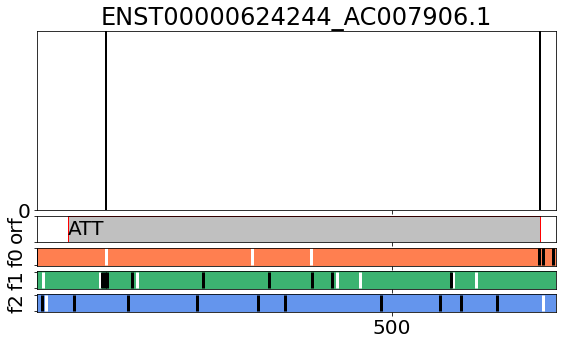

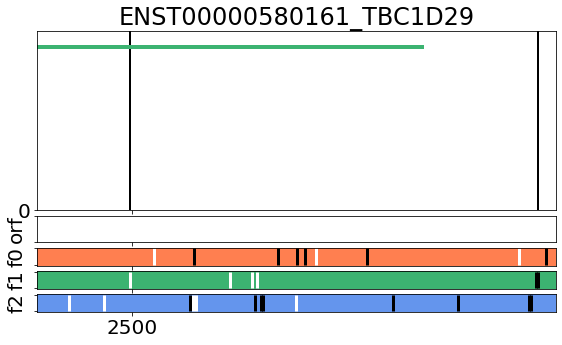

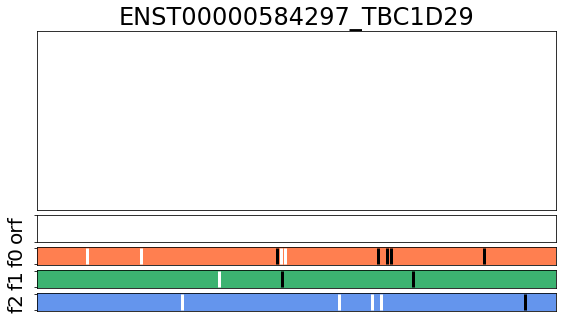

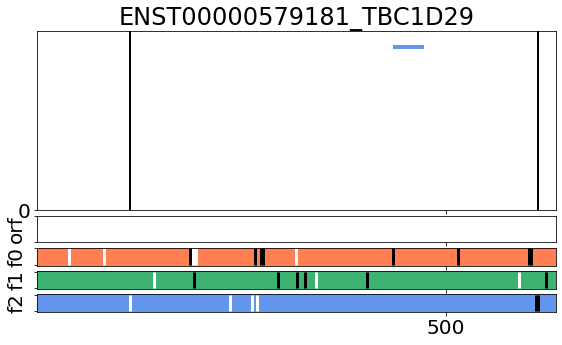

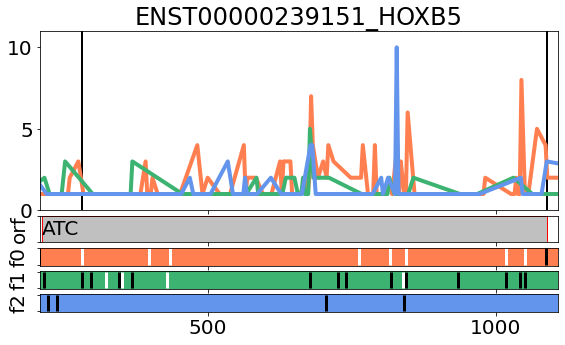

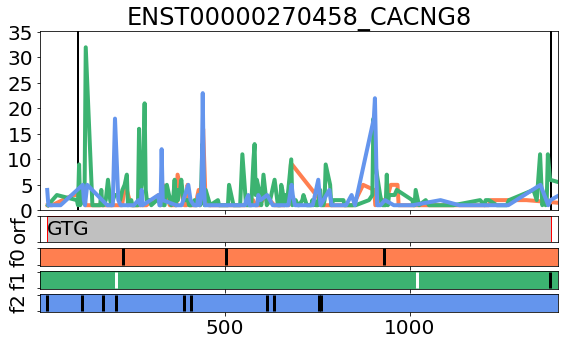

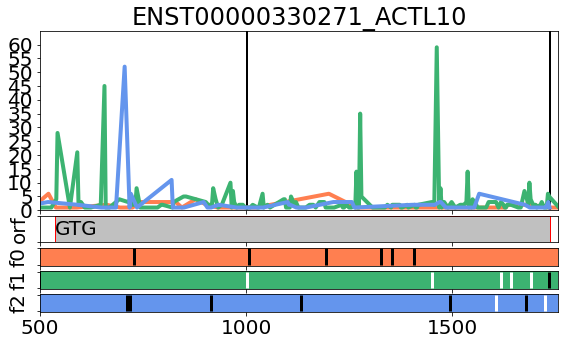

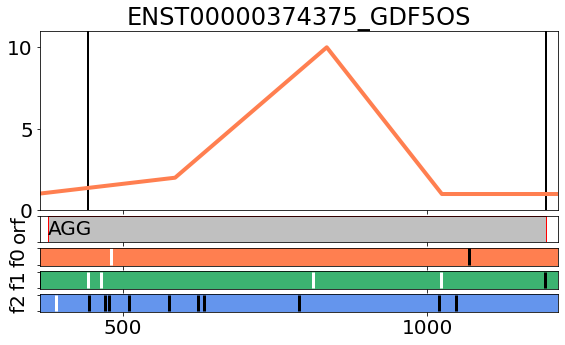

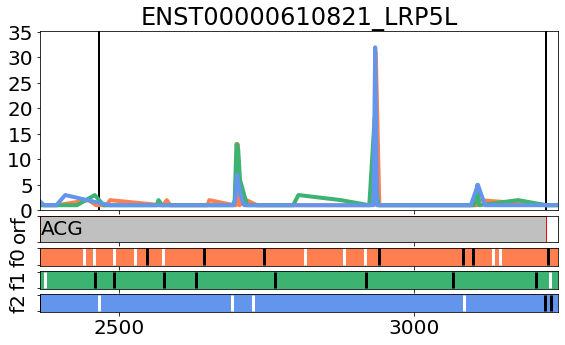

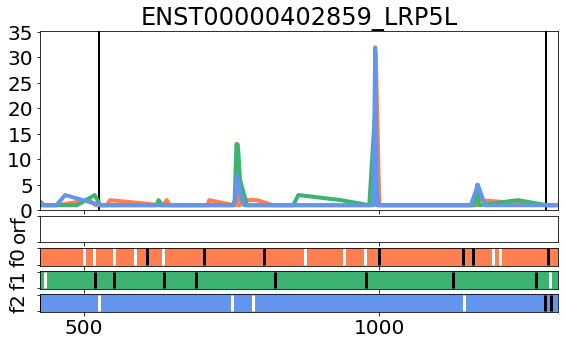

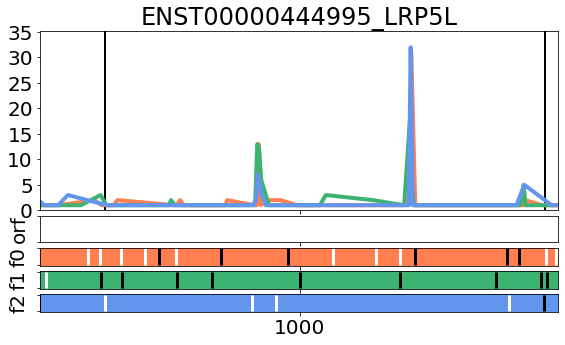

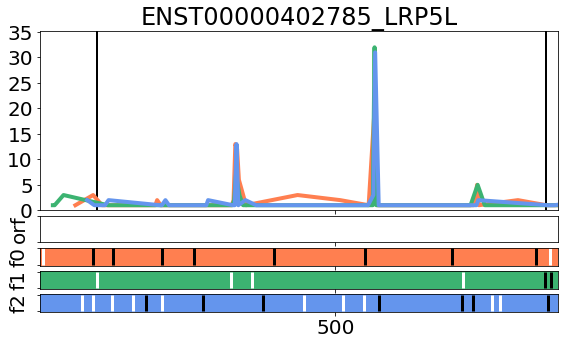

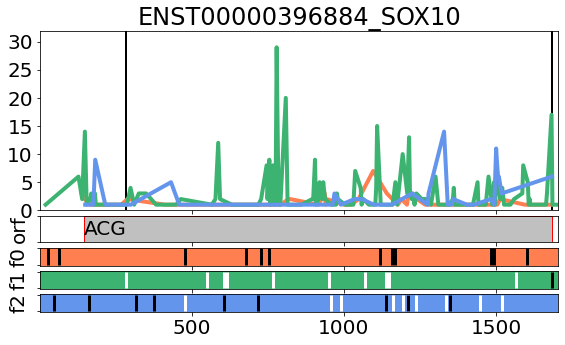

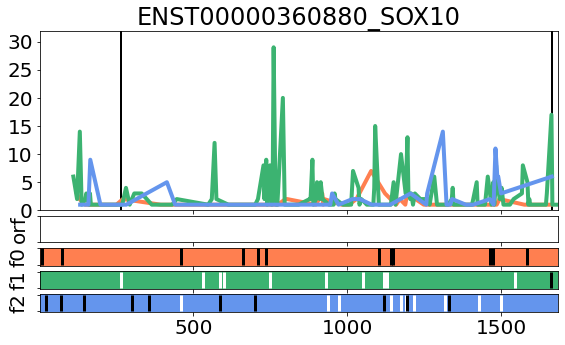

In [209]:
for gene, tr_id1 in zip(PhyloSET[PhyloSET['gene'].isin(remaining_genes2)].gene.tolist(), PhyloSET[PhyloSET['gene'].isin(remaining_genes2)].tr_id.tolist()):
    
    tr_id = tr_id1.split('.')[0]
    
    print (gene, tr_id)
    try:
        pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split(';')[0]
        pos_pred_start = PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].Riboseq_Summary.split('; ')[1].split('-')[0] 
        pre_st = pos_pred_start + '_' + pred_start
    except:
        pred_start = None
        pos_pred_start = None
        pre_st = False
    
    xlims = [PhyloSET[PhyloSET['tr_id'].str.contains(tr_id)].iloc[0].N_term_start1, 
         metadata_pc_g25[metadata_pc_g25['tr_id'].str.contains(tr_id)].iloc[0].cds_stop_pos+20]
    
    d1 = prepare_data_for_trips2(meta = meta, 
                           file_counts = 'data/TRIPSlike_plots_data_PhyloSET/%s_%s_unamb.csv' % (gene, tr_id), 
                           metadata_pc_g25 = metadata_pc_g25, 
                           tr_id = tr_id, 
                             gene = gene, 
                            predicted_ext_start=pre_st, 
                            l=10, 
                            p =5,  #y axis tick 
                             fraq = 500, #x axis 
                             cds = False,
                           figsize=(9, 5),
                             linew = 4, 
                           xlims=xlims,
                            zeros=False)

    trips_full2(d1, name = '%s_phyloset.png' % gene, font1=20, font2=24)

In [ ]:
1 PABPC1L2B
2 OAZ3
3 C1Ql2
4 MAP3K19
5 SLC6A1
6 ADCY5
7 MAB21L2
8 POMZP3
9 SLC35G5
10 C1QL3
11 ALDH3B2
12 AC007906.1
13 TBC1D29
14 HOXB5 ?
15 CACNG8 ? 
16 ACTL10 ??
17 GDF5OS
18 LRP5L
19 SOX10 ?
20 PABPC1L2A

In [210]:
out_df[out_df['gene'] == 'ACTL10'] #  SAD 

,tr_id,gene,cds_length,read_counts,normalised_read_counts,Riboseq_Summary,Coverage_value_ext
41,ENST00000330271,ACTL10,738,339,0.46,GTG; 536-1001; Rank: 1732; cov: 31.33,31.333333


SOX10: rank 3286, CDS is 0
LRP5L: rank 3720, CDS is ? 
OAZ3: 0;0
C1QL2: 4509;0
MAPK319: 5323, 0
SLC6A1: 0
ZBTB47: rank 2657, 0?
ADCY5: Rank: 5631
SLC4A4: 

In [186]:
14697/7950

1.848679245283019

# UpsetR 

In [175]:
from upsetplot import generate_data
from upsetplot import plot
from upsetplot import from_memberships

In [211]:
example = from_memberships([
    #['CDS_transl'],
    #['CDS_not_transl'],
    #['ext_rank<=500'],
    #['ext_rank<=1000'],
    #['no_ext'],
    ['ext_rank<=500', 'CDS_transl'],
    ['ext_rank<=1000', 'CDS_transl'],
    ['no_ext', 'CDS_transl'],
    ['no_ext', 'CDS_not_transl']], 
    data=[8, 14, 26, 20])

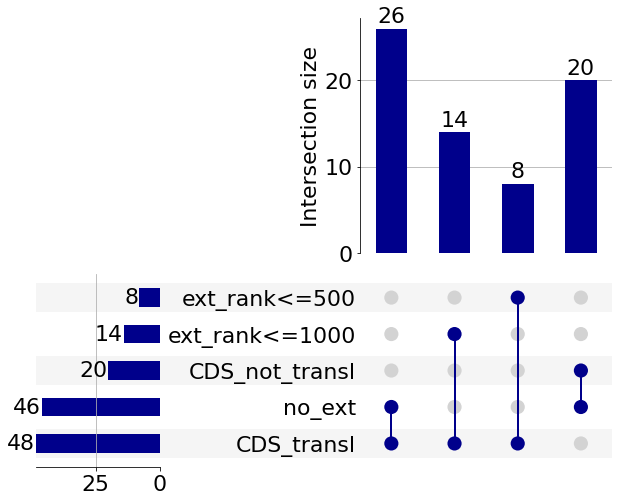

In [212]:
fig = plt.figure(figsize=(10, 8))

font = {'family' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

plot(example,show_counts='%d', 
     element_size=None, fig=fig,
    facecolor="darkblue")

plt.subplots_adjust(left=0.1, bottom=0.1,
                    wspace=0.1, hspace=0.1)

plt.show()